## Loading Packages

In [1]:
from fbprophet import Prophet
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
from preprocessing import *
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from utils import *
import warnings

# plt.style.use('dark_background')
warnings.filterwarnings("ignore")

## Loading Data

In [2]:
path = "Data/"
universe_dict = universe_select(path, "Cu")

## Preprocessing

In [3]:
# Renaming the columns to price
universe_dict = price_rename(universe_dict)
# Cleaning the dataset of any erroneous datapoints
universe_dict = clean_dict_gen(universe_dict)
# Making sure that all the points in the window have consistent lenght
universe_dict = truncate_window_length(universe_dict)
# Generate the full training dataset
df_full = generate_dataset(universe_dict, lag=5)
# Adding 1 day log returns as the normalized input variable
df_full = generate_lg_return(df_full, lag=1, target=False)
# drop_prices(df_full)

Included Instrument:
cu_shfe
cu_lme
cu_comex_p
cu_comex_s
peso
sol
bdi
ted
vix
skew
gsci


In [4]:
# Visualise the plots
# visualise_universe(universe_dict)

# Choosing whether to focus on price of log returns
df = df_full[["price_cu_lme"]]
df_full.head()
# df.head()
# df_full[["target_cu_lme"]].head()

,price_cu_shfe,price_cu_lme,price_cu_comex_p,price_cu_comex_s,price_peso,price_sol,price_bdi,price_ted,price_vix,price_skew,...,target_cu_lme,target_cu_comex_p,target_cu_comex_s,target_peso,target_sol,target_bdi,target_ted,target_vix,target_skew,target_gsci
date,,,,,,,,,,,,,,,,,,,,,
2006-08-29,68160.0,7410.0,3.423,12440.0,537.5,3.246,3750.0,5.083,12.28,126.53,...,0.069838,0.064484,-0.074925,0.001487,-0.000925,0.034595,-0.018466,0.028103,-0.017701,-0.016719
2006-08-30,67650.0,7465.0,3.365,12440.0,538.0,3.235,3795.0,5.051,12.22,125.52,...,0.077432,0.095445,-0.040772,0.002784,0.002470,0.021377,-0.016569,0.117237,-0.019549,-0.023995
2006-08-31,67630.0,7719.0,3.469,12377.0,540.5,3.243,3847.0,5.051,12.31,123.22,...,0.040371,0.055098,-0.023627,-0.002779,0.000617,0.010601,-0.016770,0.120037,-0.012741,-0.034150
2006-09-01,70140.0,7607.0,3.475,11788.0,537.7,3.243,3875.0,5.001,11.96,124.59,...,0.029277,0.029210,0.014318,0.000558,0.000925,0.010014,-0.011261,0.095614,-0.002009,-0.027833
2006-09-04,71240.0,7669.0,3.475,11788.0,536.0,3.243,3882.0,5.001,11.96,124.59,...,-0.025488,-0.011869,0.122935,0.006138,0.001848,0.016859,-0.011665,0.082612,0.011174,-0.038619


## Additive Model

In [6]:
def create_prophet_dataset(df):
    """Creates a dataframe that has data in the 
    format that works with facebooks additive 
    modelling software: fbprophet"""
    d = {"ds":df.index, "y":df}
    df = pd.DataFrame(data=d)
    df.reset_index(inplace=True)
    df = df.drop('date', 1)
    return df


# Estimated runtime = 200 mins
def prophet_prediction(df, window_start=0, window_length=264):
    """Returns a dataframe of out of sample predictions
    trained on a growing percentage of available training data
    """
    # The prediction offset in business days
    week_diff = 5
    month_diff = 22
    quarter_diff = 66
    
    # Creating the dataframe for predictions
    df_preds = df.copy()
    # Making df columns for the predicted values
    df_preds["y_pred_week"] = np.nan
    df_preds["y_pred_month"] = np.nan
    df_preds["y_pred_quarter"] = np.nan
    
    it = 0
    window_end = window_start + window_length
    
    while it <= len(df.index) - window_length: 
        
        print("Percentage Complete:", 100 * it/(len(df.index) - window_length))
        
        # Create training window
        window_start = it
        window_end = window_start + window_length
        df_train = df.iloc[window_start:window_end].copy()

        # Fitting the model
        model = Prophet(daily_seasonality=True)
        # Fit the data to the dataset
        model.fit(df_train)
        
        # Make predictions
        # Starting at the beginning of the test dataset there should be
        week_pred_date = df[df.index == [df_train.index[-1] + week_diff]]
        month_pred_date = df[df.index == [df_train.index[-1] + month_diff]]
        quarter_pred_date = df[df.index == [df_train.index[-1] + quarter_diff]]

        week_pred = model.predict(week_pred_date)[["ds", "yhat"]]
        month_pred = model.predict(month_pred_date)[["ds", "yhat"]]
        quarter_pred_date = model.predict(quarter_pred_date)[["ds", "yhat"]]

        # Finding the location in df_test with the date that 
        # we want to fill and setting the predicted value equal to the prediction
        df_preds.loc[df_preds['ds'] == week_pred.iloc[0]["ds"], 'y_pred_week'] = week_pred["yhat"].values[0]
        df_preds.loc[df_preds['ds'] == month_pred.iloc[0]["ds"], 'y_pred_month'] = month_pred["yhat"].values[0]
        df_preds.loc[df_preds['ds'] == quarter_pred_date.iloc[0]["ds"], 'y_pred_quarter'] = quarter_pred_date["yhat"].values[0]
        it+=1
        
    # Renaming the columns
    df_preds.rename(columns={'y':"y_true"}, inplace=True)
    return df_preds

In [7]:
df = create_prophet_dataset(df_full["1day_lg_return_cu_lme"])

## Demonstration of how one training cycle works
This was done on price instead of log returns because it is more easily visualised

In [8]:
# Create the dataframe in a format that works with prophet
df = create_prophet_dataset(df_full["1day_lg_return_cu_lme"])
window_length = 264
df_train = df.iloc[:window_length].copy()
df_test = df.iloc[window_length:(window_length + 66)].copy()

model = Prophet(daily_seasonality=True, weekly_seasonality=True, yearly_seasonality=True)
model.fit(df_train)
forecast = model.predict(df_test.reset_index()[["ds"]])[["ds", "yhat"]]
df_test = pd.merge(df_test, forecast, on="ds")

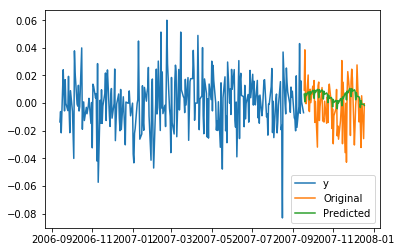

In [9]:
plt.plot(df_train["ds"], df_train["y"])
plt.plot(df_test["ds"], df_test["y"], label="Original")
plt.plot(df_test["ds"], df_test["yhat"], label="Predicted")
plt.legend()
plt.show()

In [14]:
df = df_test.merge(df_full[["price_cu_lme"]], left_on='ds', right_on=df_full[["price_cu_lme"]].index)
df["inverse_price"] = np.nan
# Shift of 1 is to line up the log returns price with the right day
df["inverse_price"] = inverse_log_returns(df[["price_cu_lme"]], df[["yhat"]], lag=1, shift=1)
# df_full["inverse_price"][5:] = inverse_log_returns(df[["price_cu_lme"]], df[["yhat"]])
# len(inverse_log_returns(df[["price_cu_lme"]], df[["yhat"]]))

In [15]:
df.head()

,ds,y,yhat,price_cu_lme,inverse_price
0,2007-09-18,0.009477,0.006451,7633.0,NaN
1,2007-09-19,0.038550,0.001030,7933.0,7640.862841
2,2007-09-20,-0.000126,0.007067,7932.0,7989.263048
3,2007-09-21,-0.000378,0.005406,7929.0,7975.000155
4,2007-09-24,0.020349,0.008088,8092.0,7993.388439


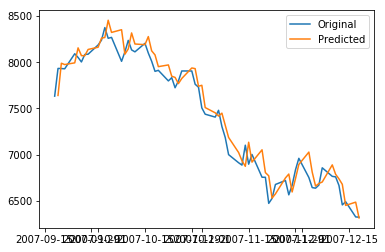

In [18]:
plt.plot(df_test["ds"], df["price_cu_lme"], label="Original")
plt.plot(df_test["ds"], df["inverse_price"], label="Predicted")
plt.legend()
plt.show()

#### As can be seen. The model is initially quite accurate with the inaccuracy increasing over time
As the predictions are made at 1 week, 1 month and 1 quarter it is hoped that the inaccuracy won't grow continuously 

In [201]:
# model.plot_components(forecast)

## Additive Model Rolling Window

Selected a window size of 264 which is equivilent to one year in business days

In [ ]:
df_preds = prophet_prediction(df, window_start=0, window_length=264)